Following this tutorial: https://zindi.africa/learn/spot-the-mask-challenge-tutorial-a-deep-learning-approach

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Keras is a deep learning framework built for Python which provides methods to train deep learning models. Keras has built-in support for CNNs (for computer vision) and has a user-friendly API that makes it easy to quickly prototype deep learning models.

Importing the sequential method, means that all the layers in the model will be arranged in sequence. The importance of ImageDataGenerator is to generate batches of tensor image data with real-time data augmentation. It has very many useful functions such as rescaling, rotating, zooming etc.

The keras.layers import gives us access to layers that we need to build our CNN which are described above. Layers are the building blocks of neural networks.

Optimizers are necessary for improving your model speed and performance. Optimizers shape the model into its most accurate form by playing with model weights.

VGG16 is a convolutional neural network architecture which provides 16 layers. Its a pretrained model. VGG16 is a model employs the transfer learning architecture. Transfer learning is the art of reusing a model on one task and repurposing it on another task.

Pandas library provides built-in methods for data manipulation.

Matplotlib is used for creating graphs where necessary when building our model.

The IPython.display imports a method for viewing images within the notebook.

In [4]:
# Importing the relevant libraries
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random
from IPython.display import Image as ShowImage
# Keras libraries
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization,GlobalMaxPooling2D
from tensorflow.keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from keras.models import Model

In [30]:
# Reading the data
train_labels = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Data/train_labels.csv")

# Show the first 5 rows
train_labels.head()

,image,target
0,tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg,0
1,rxgismgsvmaayzjarbfjaljhqmpbrt.jpg,1
2,uuzshfrhkgrkolhwdvliqauzulurnz.jpg,0
3,mjspxsagzusaznvnyxgamtrlqkqklp.jpg,0
4,rlbmuajgezfiddjzlyeoupxpqubkpt.jpg,1


<Axes: >

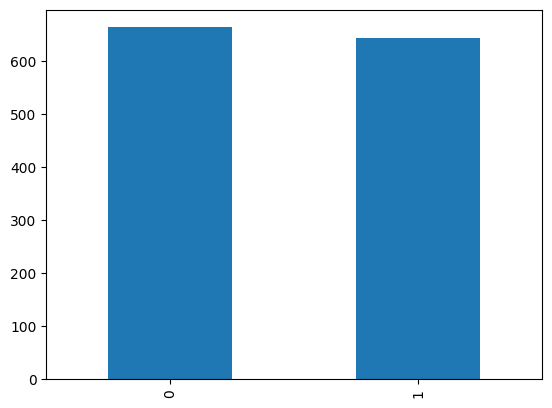

In [6]:
train_labels['target'].value_counts().plot.bar()

In [7]:
train_labels['target'].value_counts()

0    664
1    644
Name: target, dtype: int64

In [8]:
# Extracting the zip file
!unzip -q "/content/drive/My Drive/Colab Notebooks/Data/images.zip" -d "/content/drive/My Drive//Colab Notebooks/Data/"

replace /content/drive/My Drive//Colab Notebooks/Data/images/wiovvusmzmxindaealykgesxwwleql.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


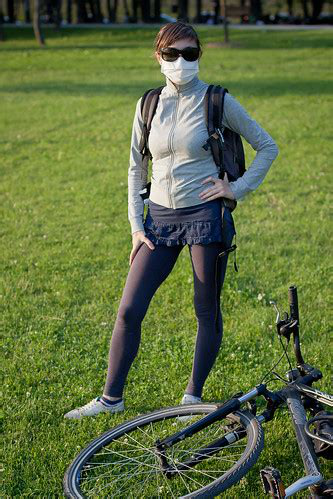

In [32]:
# We can view the images with the ShowImage functionality
ShowImage("/content/drive/My Drive/Colab Notebooks/Data/images/aadawlxbmapqrblgxyzarhjasgiobu.png")

If you found this fun, you can also use the OpenCV Library to view images!

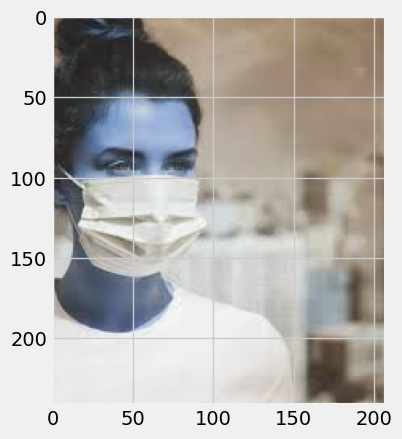

In [33]:
import cv2
import random
import os

# This stores the location of the data source
data = os.listdir("/content/drive/My Drive/Colab Notebooks/Data/images")

# Picking random sample from data list
sample = random.choice(data)

# The imread method loads image from the sprcified file
img = cv2.imread("/content/drive/My Drive/Colab Notebooks/Data/images/"+sample)

# The cmap parameter displays the image in gray
plt.imshow(img, cmap="gray")

Sample_submission.csv

This is the file that is used for making submissions after you have created your model.

We should replace the target variables (0,1) into categories (mask, unmask) using the replace method.

In [34]:
# train_labels["target"] = train_labels["target"].replace({0: 'unmask', 1: 'mask'})

In [35]:
# Save the trained model
# model.save("/content/drive/My Drive/Colab Notebooks/Data/masked_model.keras")

# To load the saved model later, you can use:
# loaded_model = load_model("/content/drive/My Drive/Colab Notebooks/Data/trained_model.h5")

## Climbing the Ladder: Image Recognition for ML Competitions (Tutorial)

### Experiment 1: Baseline Model

Before we get fancy, we're going to assume you're already using some good practices in your model. Specifically:

1. Transfer learning
2. Data Augmentation

Specifically, we will use [this tutorial](https://zindi.africa/learn/climbing-the-ladder-image-recognition-for-ml-competitions-tutorial)

Cyclic learning rates, choosing a good learning rate, gradually unfreezing and training a pre-trained model... all techniques that have become mainstream in the past few years. You'll see fancy LR schedulers varying the LR, and everyone wants to invent the latest profile. Use whatever comes with your library - see the demo notebook where we use lr_find and fit_one_cycle methods from fastai.

In [62]:
!pip install fastai2 --upgrade

In [37]:
import fastai2
from fastai2 import *
from sklearn.metrics import log_loss as skll
import random
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('fivethirtyeight')
%matplotlib inline

In [38]:
import copy

df = copy.deepcopy(train_labels)

df['file_path'] = 'all_data/'+df['image']+'.JPG'
df.head(3)

,image,target,file_path
0,tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg,0,all_data/tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg.JPG
1,rxgismgsvmaayzjarbfjaljhqmpbrt.jpg,1,all_data/rxgismgsvmaayzjarbfjaljhqmpbrt.jpg.JPG
2,uuzshfrhkgrkolhwdvliqauzulurnz.jpg,0,all_data/uuzshfrhkgrkolhwdvliqauzulurnz.jpg.JPG


In [39]:
# Set up a consistent validation set, to use for local scoring and comparing our different models
df = df.sample(frac=1.0).reset_index() # Shuffle for good measure
df['val'] = [int(random.random()>0.8) for _ in df.values] # 80% train, 20% val
df['val'].value_counts() # Check the number of rows in train (0) and val(1)

0    1043
1     265
Name: val, dtype: int64

We're going to make a decent model here, without digging too deeply into what it's doing - we'll unpack this as we move forward, but for now this should give us a score to compare everything else to.

You'll notice we're playing with the datablock API here. There are simpler ways to do this (see the docs for fastai v1 or v2 - both have convenience functions). But we'll be customising these later to have some fun and boost our scores.

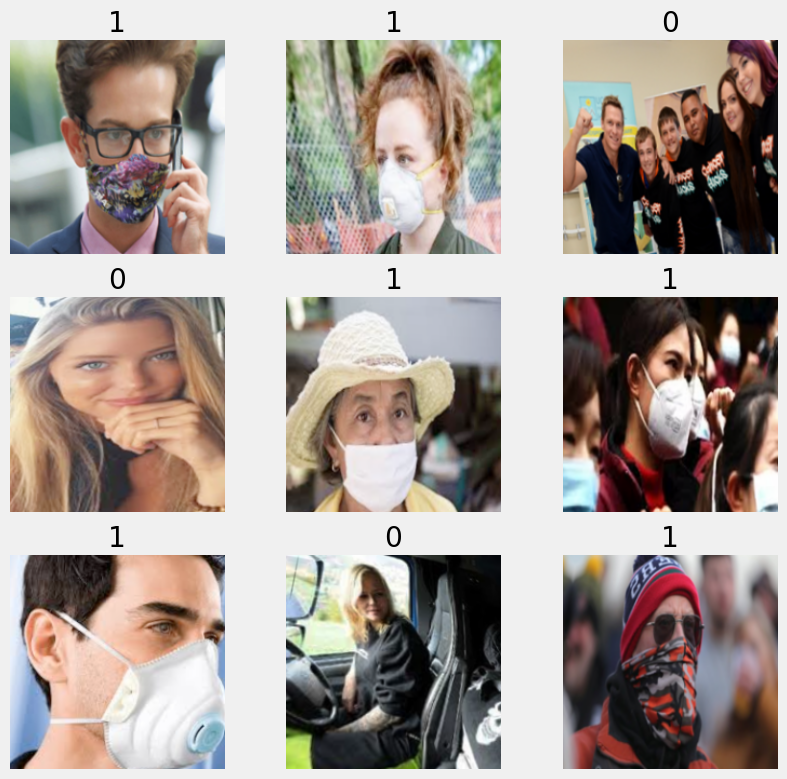

In [40]:
# We're using custom functions to get the input image and the label
from fastai.data.all import *
from fastai.vision.all import *
from fastai.vision.augment import Resize
from PIL import Image

def get_x(ID):
    # Load the image
    im = Image.open(f'/content/drive/My Drive/Colab Notebooks/Data/images/{ID}')

    # Convert grayscale image to RGB if it has only one channel
    # if im.mode == 'L':
    im = im.convert('RGB')

    # Resize the image to a consistent size if needed
    im = im.resize((224, 224))

    # Return the image as a numpy array
    return np.array(im)

# And the label
def get_y(ID):
  label = df.loc[df.image == ID]['target'].values[0]
  return int(label)

# Get the list of Image IDS:
def get_im_ids(path):
  return df.image.values

# And build the datablock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_im_ids,
    get_x=get_x,
    get_y=get_y,
    splitter=IndexSplitter(np.argwhere(df['val'].values == 1)),
    batch_tfms=aug_transforms(size=224, min_scale=0.75),
    # Add Resize transform to ensure all images have the same size
    item_tfms=Resize((224, 224))
)

dls = dblock.dataloaders(
    Path(''),
    bs=16,
    seed=42,
    batch_tfms=[*aug_transforms(size=(3, 244,244)),
                Normalize.from_stats(*imagenet_stats)],
    )
dls.show_batch()

In [41]:
# Create the learner
learn = vision_learner(dls, resnet34)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 125MB/s]


In [42]:
learn.fine_tune(3) # The 3 is the number of epochs

epoch,train_loss,valid_loss,time
0,0.586279,0.381351,05:15


epoch,train_loss,valid_loss,time
0,0.357511,0.419054,07:03
1,0.235674,0.196413,06:57
2,0.127848,0.191637,06:55


In [43]:

# Here we are creating a list of pictures - we are appending images on the list.
# Our data source is the original data before splitting to test and train data
target=[]

for i in data:
    flag=0
    for j in train_labels["image"]:
        if(i==j):
            flag=1
            break
    if(flag==0):
        target.append(i)

#creating a test dataframe with images and the target is umask for all images
test = pd.DataFrame({
    'image': target,
    'target':"unmask"
})
print(test.shape)
test.head()

(509, 2)


,image,target
0,zkmcdlytdocncvgmigqhklfvjqwrni.jpg,unmask
1,bqjjodotjhmmchkiityjpmglknkzdq.jpg,unmask
2,iuzfasnekvmbbmtqetpnmrxcyopfie.jpg,unmask
3,goxowiqsuthbriuqxiespbmeegqkvf.jpg,unmask
4,urfpnxaaxslypipkziqixilgvtitse.jpg,unmask


In [44]:
# Create a test dataloader and get predictions
tdl = learn.dls.test_dl(test['image'].values)
test_preds, test_labels = learn.get_preds(dl=tdl, reorder=False)

In [45]:
# Make a submission dataframe
sub = pd.DataFrame({
    'image':test['image'],
    'target':[p[1] for p in test_preds.numpy()]
})
print(sub.shape) # 509, 2
sub.head()

(509, 2)


,image,target
0,zkmcdlytdocncvgmigqhklfvjqwrni.jpg,1.948853e-05
1,bqjjodotjhmmchkiityjpmglknkzdq.jpg,9.999940e-01
2,iuzfasnekvmbbmtqetpnmrxcyopfie.jpg,4.517639e-08
3,goxowiqsuthbriuqxiespbmeegqkvf.jpg,9.875441e-01
4,urfpnxaaxslypipkziqixilgvtitse.jpg,2.715336e-09


In [46]:
sub.to_csv("/content/drive/My Drive/Colab Notebooks/Data/masked_submission2.csv", index=False)
# Score: 0.992504245

#### Pick an explicit learning rate

To explicitly pick learning rates, you can use the lr_find method to find a suitable learning rate and then use that learning rate(s) in your training.

epoch,train_loss,valid_loss,time
0,0.095992,0.199155,07:03
1,0.054337,0.175123,07:14
2,0.054934,0.183889,07:01
3,0.044517,0.174816,07:02
4,0.047217,0.172900,07:00


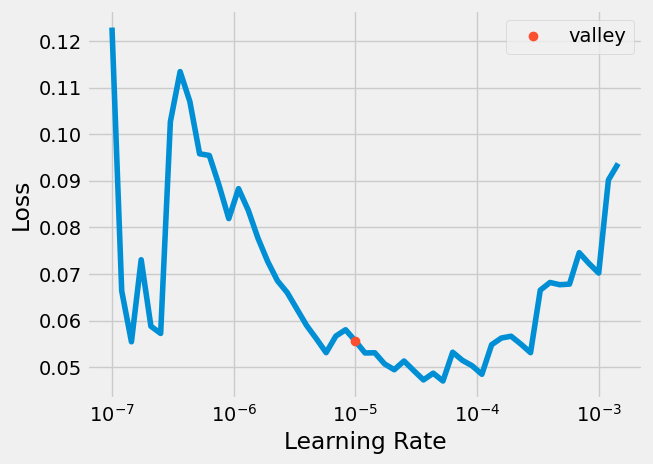

In [48]:
# Find a suitable learning rate
lr_min = learn.lr_find()

# Choose a learning rate(s) based on the plot generated by lr_find
learn.fit_one_cycle(5, lr_max=lr_min)  # For example, using the minimum learning rate found

In [54]:
# Create a test dataloader and get predictions
tdl = learn.dls.test_dl(test['image'].values)
test_preds, test_labels = learn.get_preds(dl=tdl, reorder=False)

In [50]:
# Make a submission dataframe
sub = pd.DataFrame({
    'image':test['image'],
    'target':[p[1] for p in test_preds.numpy()]
})
print(sub.shape) # 509, 2
sub.head()

(509, 2)


,image,target
0,zkmcdlytdocncvgmigqhklfvjqwrni.jpg,5.394205e-05
1,bqjjodotjhmmchkiityjpmglknkzdq.jpg,9.999912e-01
2,iuzfasnekvmbbmtqetpnmrxcyopfie.jpg,2.018661e-08
3,goxowiqsuthbriuqxiespbmeegqkvf.jpg,9.997128e-01
4,urfpnxaaxslypipkziqixilgvtitse.jpg,1.512714e-09


In [72]:
sub.to_csv("/content/drive/My Drive/Colab Notebooks/Data/masked_submission3.csv", index=False)
# Score: 0.997390767

### Experiment 2: TTA For the win

In [74]:
# Compare TTA with normal predictions on the validation set
valid_preds, val_lables = learn.get_preds(ds_idx=1)
valid_preds_tta, v_ta_labels = learn.tta(ds_idx=1)

valid = df.loc[df.val == 1]
print('normal score:', skll(valid['target'], valid_preds))
print('TTA score:', skll(valid['target'], valid_preds_tta))

normal score: 0.179945072593563
TTA score: 0.11270704353709167


In [75]:
# Use TTA on the test set and save predictions
test_preds_tta, test_labels_tta = learn.tta(dl=tdl)
sub = pd.DataFrame({
    'image':test['image'],
    'target':[p[1] for p in test_preds_tta.numpy()]
})
sub.to_csv("/content/drive/My Drive/Colab Notebooks/Data/masked_submission4.csv", index=False)